In [191]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d

## NACA 4 digits airfoils
Information was taken from http://www.aerospaceweb.org/question/airfoils/q0041.shtml

In [295]:
def NACA4(s):
    # Definition of the NACA profile as a string 'XXXX'
    NACA = s
    # fixed chord line
    c = 1 
    # NACA 4 digits are defined as XXXX = m p (pt)
    # maximum camber
    m = int(int(NACA)/1e3)/1e2 
    # location of maximum camber
    p = int((int(NACA)-m*1e5)/1e2)/1e1
    # percentage of thickness with respect to the chord
    pt = int((int(NACA)-m*1e5-p*1e3)) 
    
    # figure declaration
    fig = plt.gcf()
    fig.set_size_inches(20,12)
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    
    # mean camber line definition
    # non-symmetrical airfoil
    if p != 0:
        # coordinates of the X axis
        x = np.append(np.linspace(0,p/100*c,15)[:-1],np.linspace(p/100*c,c,60))
        # masked array to create the piece-wise function
        x_pc = x<(p*c) 
        # upper and lower surfaces
        yc1 = ((c*m)/(p**2))*(2*p*(x/c)-(x/c)**2)
        yc2 = ((c*m)/((1-p)**2))*((1-2*p)+2*p*(x/c)-(x/c)**2)
        
        # matrix for the whole airfoil surface
        yc = np.zeros(np.shape(x))
        # store the surfaces as corresponds
        for i in range(np.shape(x)[0]):
            if x_pc[i] == True:
                yc[i] = yc1[i]
            else:
                yc[i] = yc2[i]

        # compute the mean camber line derivative for each surface
        dyc1dx = (2*m)/(p**2)*(p-(x/c))
        dyc2dx = (2*m)/((1-p)**2)*(p-(x/c))
        # matrix for the whole airfoil mean camber line derivative
        dycdx = np.zeros(np.shape(x))
        # store the mean camber line derivative as corresponds        
        for i in range(np.shape(x)[0]):
            if x_pc[i] == True:
                dycdx[i] = dyc1dx[i]
            else:
                dycdx[i] = dyc2dx[i]
        # compute the angle of the derivative
        theta = np.arctan(dycdx)

        # plot the mean camber line
        ax1.plot(x,yc1,'--k',label='yc1')
        ax1.plot(x,yc2,'-.k',label='yc2')
        ax1.plot(x,0.02*x_pc,':',color='grey', label='Masked matrix')
        ax1.plot(x,yc,'b-',label='Mean camber Line')
        ax1.legend()
        
    # symmetric airfoil 
    else:
        # coordinates of the X axis
        x = np.linspace(0,c,75)
        # matrix for the whole airfoil surface
        yc = np.zeros(np.shape(x))

        # plot the mean camber line
        ax1.plot(x,yc,'b-',label='Mean camber Line')
        ax1.legend()

    # compute the thicknes
    # non-symmetrical airfoil    
    if p != 0:
        # compute the thickness
        yt = 5*pt/100*(0.2969*np.sqrt(x/c)-0.1260*(x/c)-0.3516*(x/c)**2+0.2843*(x/c)**3-0.1036*(x/c)**4)
        
        # correct the coordinates of the mean camber line
        xu = x - yt*np.sin(theta)
        xl = x + yt*np.sin(theta)
        yu = yc + yt*np.cos(theta)
        yl = yc - yt*np.cos(theta)

        # plot the airfoil
        ax2.set_xlim(-c*0.1,1.1*c)
        ax2.axis('equal')
        ax2.axis('off')
        ax2.plot(xu,yu,'b')
        ax2.plot(xl,yl,'b')
        ax2.fill_between(x, yu, yl,facecolor='blue',alpha=0.1)
        ax2.plot(x,yc,'r',linewidth=0.7)
        ax2.plot([0,c],[0,0],'g',linewidth=0.6)
        
        return xu, xl, yu, yl

    # symmetric airfoil     
    else:
        # compute the thickness
        yt = 5*pt/100*(0.2969*np.sqrt(x/c)-0.1260*(x/c)-0.3516*(x/c)**2+0.2843*(x/c)**3-0.1036*(x/c)**4)
        
        # plot the airfoil
        ax2.set_xlim(-c*0.1,1.1*c)
        ax2.axis('equal')
        ax2.axis('off')
        ax2.plot(x,yt,'b')
        ax2.plot(x,-yt,'b')
        ax2.fill_between(x, -yt, yt,facecolor='blue',alpha=0.1)
        ax2.plot(x,yc,'r',linewidth=0.7)
        ax2.plot([0,c],[0,0],'g',linewidth=0.6)

        return x, x, yt, -yt

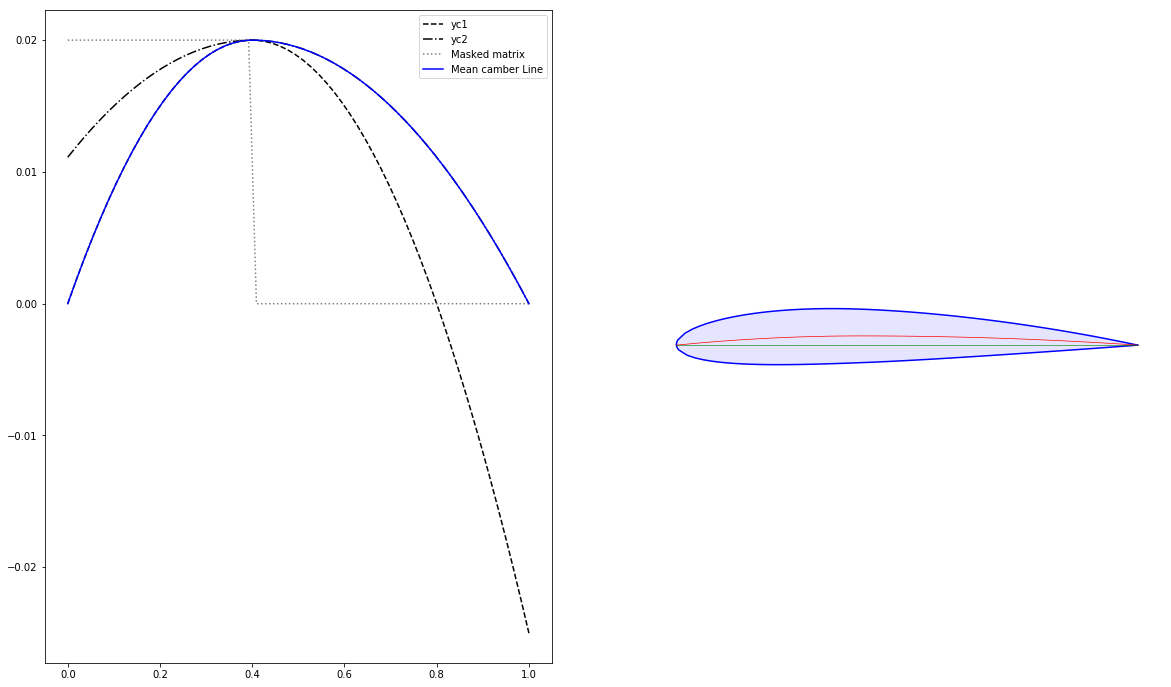

In [296]:
# sample call to the function
xu, xl, yu, yl = NACA4('2412')

## simpleGrading for future mesh generation

Equations for $\texttt{simpleGrading}$ are:

$$
\begin{Bmatrix}
\delta_1 = k \delta_0 && \delta_2= k\delta_1 = k^2 \delta_0 && \delta_{N-1}=k^{N-1}\delta_0 \\
&& \varepsilon = \dfrac{\delta_e}{\delta_s} = \dfrac{\delta_{N-1}}{\delta_0} && \delta_{N-1}=\varepsilon\delta_0
\end{Bmatrix} \longrightarrow {\varepsilon = k^{N-1}}
$$


$$
L= \sum\limits^{N-1}_{i=0} \delta_i = \delta_0 + \delta_1 + \delta_2 + \delta_3 + ... + \delta_{N-1} = k^0\delta_0 + k^1\delta_0 + k^2\delta_0 + k^3\delta_0 + ... + k^{N-1}\delta_0 = \delta_0 \sum\limits^{N-1}_{i=0} k^{i} \longrightarrow \delta_0 = \dfrac{L}{\sum\limits^{N-1}_{i=0} k^i} 
$$

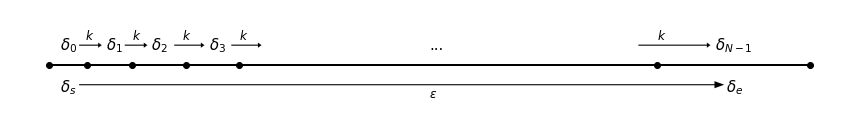

In [297]:
# image of the simple grading
fig, ax = plt.subplots(1, figsize=(15,2))
ax.plot([0,2],[0,0],'k',lw=2)
ax.plot([0.0,0.1,0.22,0.36,0.5,1.6,2.0],[0,0,0,0,0,0,0],'ko')
ax.text(0.03, 0.015,  r'$\delta_0$', fontsize=15)
ax.text(0.15, 0.015, r'$\delta_1$', fontsize=15)
ax.text(0.27, 0.015, r'$\delta_2$', fontsize=15)
ax.text(0.42, 0.015, r'$\delta_3$', fontsize=15)
ax.text(1, 0.015, r'...', fontsize=15)
ax.text(1.75, 0.015, r'$\delta_{N-1}$', fontsize=15)
ax.text(0.03, -0.028, r'$\delta_s$', fontsize=15)
ax.text(1.78, -0.028, r'$\delta_e$', fontsize=15)
ax.arrow(0.08,0.02,0.05,0, lw=0.1, head_width=0.005, head_length=0.009, fc='k', ec='k')
ax.arrow(0.20,0.02,0.05,0, lw=0.1, head_width=0.005, head_length=0.009, fc='k', ec='k')
ax.arrow(0.33,0.02,0.07,0, lw=0.1, head_width=0.005, head_length=0.009, fc='k', ec='k')
ax.arrow(0.48,0.02,0.07,0, lw=0.1, head_width=0.005, head_length=0.009, fc='k', ec='k')
ax.arrow(1.55,0.02,0.18,0, lw=0.1, head_width=0.005, head_length=0.009, fc='k', ec='k')
ax.arrow(0.08,-0.02,1.67,0, lw=0.1, head_width=0.007, head_length=0.025, fc='k', ec='k')
ax.text(0.095, 0.025, r'$k$', fontsize=12)
ax.text(0.22, 0.025, r'$k$', fontsize=12)
ax.text(0.35, 0.025, r'$k$', fontsize=12)
ax.text(0.5, 0.025, r'$k$', fontsize=12)
ax.text(1.6, 0.025, r'$k$', fontsize=12)
ax.text(1, -0.033, r'$\varepsilon$', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off');

In [298]:
def simple_grading(N, expRatio, L):
    # size of each cell array
    delta = np.zeros(N) 
    # position of the nodes
    nodes = np.zeros(N+1) 

    # value of k for all the line
    kVal = expRatio**((1)/(N-1)) 
    # increment of k for each cell
    k = np.zeros(N)

    # compute that incremental k
    for i in range(N):
        k[i] = kVal**(i) 

    # first cell size 
    deltaS = L/np.sum(k)
    # size of each cell
    delta = deltaS*k 
    
    # compute the location of the nodes
    for i in range(N):
        nodes[i+1] = nodes[i] + delta[i]

    return nodes

In [299]:
def grading_plot(x): #nodes is the input from simple_grading

    # get a y-coordinate vector for the x-shape
    y = 0.5*np.ones(np.shape(x)[0])
    
    # create the figure
    fig, ax = plt.subplots(figsize=(20, 1), dpi=100)
        
    # plot the line and the nodes
    ax.set_xlim(-x[1]*0.5,1.1*x[-1])
    ax.set_ylim(0,1)
    ax.axis('off')
    ax.plot([x[0],x[-1]],[y[0],y[-1]],'k')
    ax.scatter(x,y,c='k')

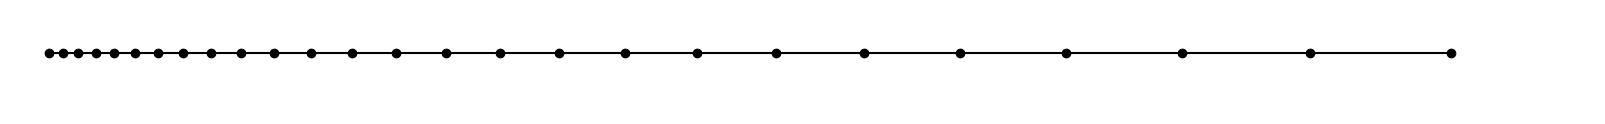

In [300]:
nodes = simple_grading(25, 10, 10)
grading_plot(nodes)

## multiGrading for future mesh generation

Simply dividing the whole length L in the number of segments specified, having for each segment a length, number of cells and expansion ratio that will go under a $\texttt{simpleGrading}$

In [301]:
def multi_grading(perc, cells, eps, N, L): 
    
    # some initial shape and value comprobations
    if np.sum(perc) != 1:
        raise ValueError('Bad percentage array input')
        return

    if np.sum(cells) != 1:
        raise ValueError('Bad cell array input')
        return
    
    if np.shape(perc)[0] != np.shape(cells)[0] or np.shape(perc)[0] != np.shape(eps)[0] or np.shape(cells)[0] != np.shape(eps)[0]:
        raise ValueError('Non equal vector definition')
        return

    # cells per segment
    segmentN = (N*cells) 

    # in case there are decimal values
    restCells = np.modf(segmentN)[0] 

    # integer value of the cells
    segmentN = np.trunc(segmentN) 
    
    # distribution of the 'decimal' parts of the cells
    i = np.sum(restCells) 

    # compute the correct subdivisions of the cells
    while i > 0:
        segmentN[np.argmax(restCells)] = segmentN[np.argmax(restCells)] + int(i)
        restCells[np.argmax(restCells)] = 0
        i -= 1
   
    # length per segment
    segmentL = (L*perc) 

    # number of nodes    
    nodes = np.zeros(N+1)
    
    # compute the location of each node in the line
    for i in range(np.shape(perc)[0]):
        nodesTemp = simple_grading(int(segmentN[i]), eps[i], segmentL[i])
        for j in range(np.shape(nodesTemp)[0]):
            if i == 0:
                nodes[j] = nodesTemp[j]
            else:
                nodes[int(np.cumsum(segmentN)[i-1]) + j] = nodesTemp[j] + nodes[int(np.cumsum(segmentN)[i-1])]

    return nodes

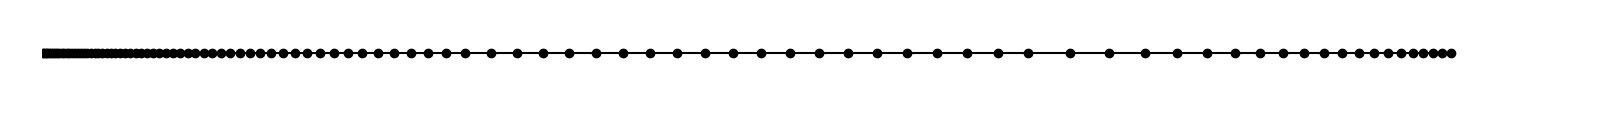

In [302]:
# definition of the grading
perc = np.array([0.3,0.4,0.3])
cells = np.array([0.6,0.2,0.2])
exp = np.array([12,1.2,0.2])

# sample calling
xAxis = multi_grading(perc, cells, exp, 100, 0.9999)
grading_plot(xAxis)

## Airfoil refinement referred to the selected horizontal grading

Given that some airfoil data is not very precise in the leading edge, this function will interpolate it from a selected horizontal grading: all points from $\texttt{xu}$ matrix (and its respectives $\texttt{yu}$ coordinates) and from $\texttt{xl}$ matrix (and $\texttt{yl}$) will be recomputed at the points stored in $\texttt{newX}$

In [303]:
def airfoilTrueX(newX, xu, yu, xl, yl):
    # get the interpolation functions for both surfaces
    yuF = interp1d(xu, yu, kind='cubic')
    ylF = interp1d(xl, yl, kind='cubic')
    # evaluate the function in the new x-axis coordinates
    yuAxis = yuF(newX)
    ylAxis = ylF(newX)
    # return the new y-axis coordinates referred to newX
    return yuAxis, ylAxis

In [304]:
yuAxis, ylAxis = airfoilTrueX(xAxis, xu, yu, xl, yl)

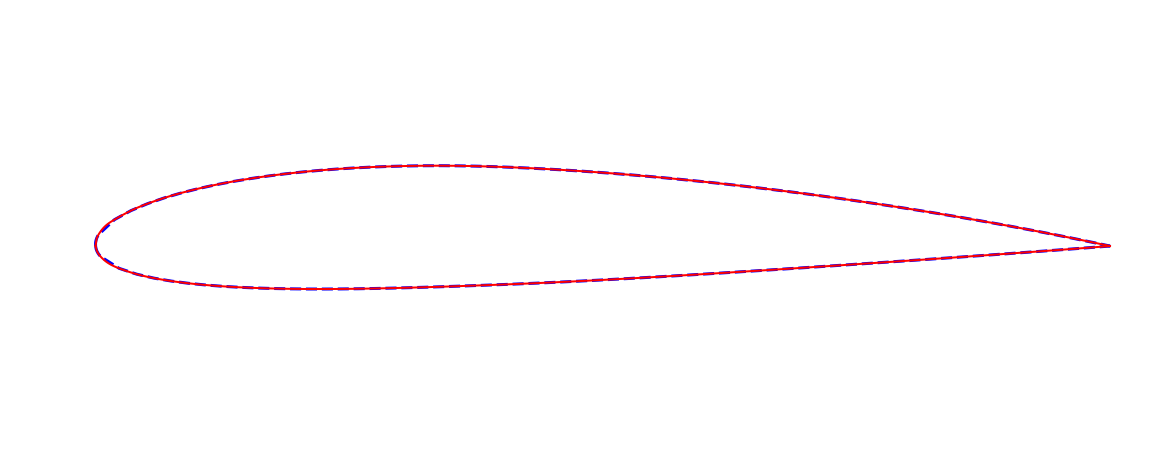

In [305]:
fig, ax1 = plt.subplots(1, figsize=(20,8))
ax1.axis('equal')
ax1.axis('off')
ax1.plot(xu,yu,'b--',linewidth = 3)
ax1.plot(xl,yl,'b--',linewidth = 3)
ax1.plot(xAxis,yuAxis,'r-', linewidth = 2)
ax1.plot(xAxis,ylAxis,'r-', linewidth = 2)

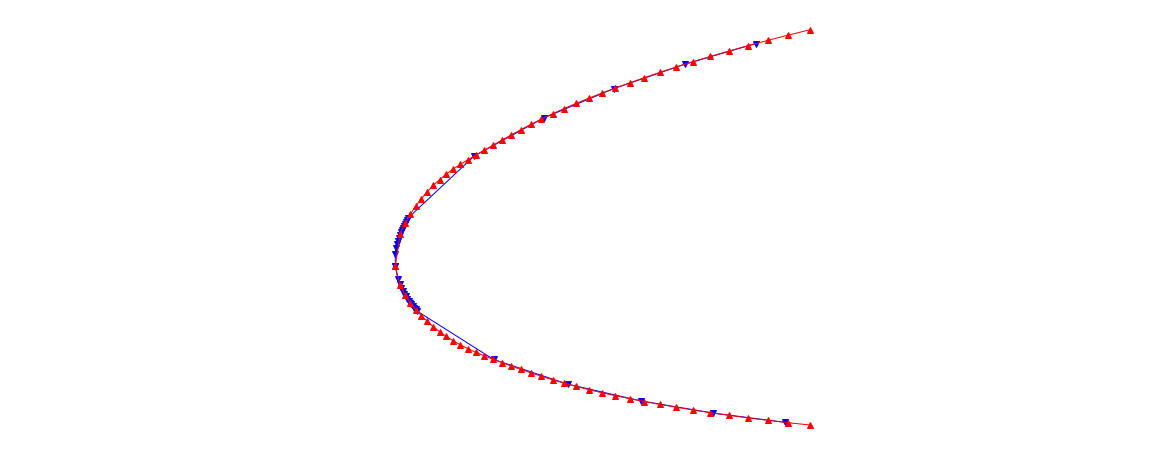

In [306]:
fig, ax1 = plt.subplots(1, figsize=(20,8))
ax1.axis('equal')
ax1.axis('off')
ax1.plot(xu[xu<0.1],yu[xu<0.1],'bv-',linewidth = 1)
ax1.plot(xl[xl<0.1],yl[xl<0.1],'bv-',linewidth = 1)
ax1.plot(xAxis[xAxis<0.1],yuAxis[xAxis<0.1],'r^-', linewidth = 1)
ax1.plot(xAxis[xAxis<0.1],ylAxis[xAxis<0.1],'r^-', linewidth = 1)

Although this is not very useful for NACA 4-airfoils (given that there is a direct computation of the value of the desired $\texttt{x}$), for other airfoils from which only some points are known, this may increase the resolution of the airfoil.

## Points storage in file

In [291]:
prof = np.zeros((np.shape(xAxis)[0],3))

# assign the values for each set, having X-Yl-Yu
prof[:, 0] = xAxis
prof[:, 1] = ylAxis
prof[:, 2] = yuAxis

# force the leading edge to be (0,0,0) and the trailing edge to be (1,0,0) to avoid inconsistent values
prof[0,:] = np.array([0.0,0.0,0.0])
prof[-1,:] = np.array([1.0,0.0,0.0])

print(prof.shape)

(101, 3)


Although a most intelligent way of saving them is beggining from the trailing edge and ending again there, having the points ordered going first towards negative X and then towards positive X (i.e. from 1 to 0 and from 0 to 1) will make smooth trailing edges. Upper surface was chosen as first one to follow.

In [293]:
# reorder the points
profile = np.zeros((2*np.shape(xAxis)[0]-1,2))

# position of the current x point
j = 0

# save the position of the upper surface
for i in range(np.shape(prof)[0]-1,-1,-1):
    profile[j,0] = prof[i,0]
    profile[j,1] = prof[i,2]
    j += 1

# save the position of the lower surface
for i in range(np.shape(prof)[0]-1):
    profile[i+np.shape(prof)[0],0] = prof[i+1,0]
    profile[i+np.shape(prof)[0],1] = prof[i+1,1]  
    
print(profile.shape)

(201, 2)


In [294]:
# save the points in a file
np.savetxt('./profile.csv', profile, delimiter=",")